# 深層学習スクラッチ 畳み込みニューラルネットワーク1

【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成

In [1]:
import numpy as np

class SimpleConv1d:
    def __init__(self, N_in=np.array([1,2,3,4]), padding=0, filter_size=np.array([3, 5, 7]), stride=1):
        self.w = filter_size
        self.b = np.array([1])
        self.x = N_in
        self.stride = stride
        self.padding = padding
        self.N_out = self.compute_out(N_in=self.x, padding=self.padding, filter_size=self.w, stride=self.stride)
        
    def compute_out(self, N_in, padding, filter_size, stride):
        N_out_shape = (len(N_in) + 2 * padding - len(filter_size)) / stride + 1
        return np.zeros(int(N_out_shape))
        
    def forward(self):
        for i in range(len(self.N_out)):
            self.N_out[i] = np.sum(self.x[0+i:len(self.w)+i] * self.w, axis=0) + 1
            
    def backward(self, loss=np.array([10, 20])):
        self.delta_w = np.zeros(self.w.size)
        self.delta_x = np.zeros(self.x.size)
        self.delta_b = np.sum(loss)
        for i in range(self.w.size):
            self.delta_w[i] = np.sum(loss * self.x[0+i:len(loss)+i])
            
        for j in range(self.x.size):
            for s in range(self.w.size):
                loss_index = j - s
                if loss_index < 0 or loss_index > self.N_out.size - 1:
                    pass
                else:
                    self.delta_x[j] += loss[loss_index] * self.w[s]

【問題2】1次元畳み込み後の出力サイズの計算

In [2]:
def compute_out(N_in, padding, filter_size, stride):
    return (N_in + 2 * padding - filter_size) / stride + 1

In [3]:
# 確認
N_in = 10
padding = 0
filter_size = 3
stride = 1
print(f'計算された出力サイズ：{compute_out(N_in, padding, filter_size, stride)}')

計算された出力サイズ：8.0


【問題3】小さな配列での1次元畳み込み層の実験

In [4]:
simple_comv = SimpleConv1d()

# 順伝搬確認
simple_comv.forward()
print(simple_comv.N_out)

# 逆伝搬確認
simple_comv.backward()
print(simple_comv.delta_w, simple_comv.delta_b, simple_comv.delta_x)

[35. 50.]
[ 50.  80. 110.] 30 [ 30. 110. 170. 140.]


【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成

In [5]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）

a = np.array([[16, 22], [17, 23], [18, 24]]) # shape(3, 2)で、（出力チャンネル数、特徴量数）である。

In [6]:
import numpy as np

class MultiConv1d:
    def __init__(self, N_in=None, filter_size=None, stride=1, padding=0):
        self.w = filter_size
        self.b = np.array([1, 2, 3]) # 題意に沿って設定
        self.x = N_in
        self.stride = stride
        self.padding = padding
        self.N_out = np.zeros((self.w.shape[0], self.w.shape[1]))
        
    def forward(self):
        for i in range(self.N_out.shape[0]):
            for j in range(self.N_out.shape[1]):
                self.N_out[i, j] = np.sum(self.w[i].reshape(-1) * self.x[:, j:self.w[i].shape[1]+j].reshape(-1)) + self.b[i]

In [7]:
multi = MultiConv1d(N_in=x, filter_size=w)

# 順伝搬確認
multi.forward()
print(multi.N_out)

[[16. 22.]
 [17. 23.]
 [18. 24.]]


【問題5】（アドバンス課題）パディングの実装

【問題6】（アドバンス課題）ミニバッチへの対応

【問題7】（アドバンス課題）任意のストライド数

【問題8】学習と推定

In [68]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W :
        """
        return self.sigma * np.random.rand(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        B :
        """
        return self.sigma * np.random.rand(n_nodes2)
        
    
class SimpleConv1d:
    # ここに入るn_nodes1:バッチサイズ×画素数（20 * 784）
    def __init__(self, stride=1, padding=0):
        self.padding = padding
        self.stride = stride
        self.filter_size = 7681
        self.W = np.random.rand(self.filter_size)
        self.B = np.array([1])
        
    def compute_out(self, N_in, padding, filter_size, stride):
        N_out_shape = (len(N_in) + 2 * padding - filter_size) / stride + 1
        return np.zeros(int(N_out_shape))
        
    def forward(self, X):
        self.x = X
        N_out = self.compute_out(X, self.padding, self.filter_size, self.stride)
        for i in range(len(N_out)):
            N_out[i] = np.sum(self.x[0+i:self.W.shape[0]+i] * self.W, axis=0) + 1
        return N_out
            
    def backward(self, dA):
        self.delta_w = np.zeros(self.W.size)
        self.delta_x = np.zeros(self.x.size)
        self.delta_b = np.sum(dA)
        self.B = self.delta_b
        for i in range(self.W.size):
            self.delta_w[i] = np.sum(dA * self.x[0+i:len(dA)+i])
            self.W[i] = self.delta_w[i]
            
#         for j in range(self.x.size):
#             for s in range(self.W.size):
#                 loss_index = j - s
#                 if loss_index < 0 or loss_index > dA.size - 1:
#                     pass
#                 else:
#                     self.delta_x[j] += dA[loss_index] * self.W[s]
                    
        dZ = self.delta_x
        return dZ
    
class Xavier:
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        return np.random.normal(0, np.sqrt(1 / self.n_nodes1), (n_nodes1, n_nodes2))

    def B(self, n_nodes2):
        return np.random.normal(0, np.sqrt(1 / self.n_nodes1), n_nodes2)
    
class He:
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        return np.random.normal(0, np.sqrt(2 / self.n_nodes1), (n_nodes1, n_nodes2))

    def B(self, n_nodes2):
        return np.random.normal(0, np.sqrt(2 / self.n_nodes1), n_nodes2)

class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer_z, layer_a : 更新前の層のインスタンス
        """
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return
    
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.H_i = 0
        self.B_i = 0
    def update(self, layer_z, layer_a, layer):
        self.H_i += np.dot(layer_z, layer_a) ** 2
        self.B_i += layer_a.sum(axis=0) ** 2
        layer.W -= self.lr * np.sqrt(1 / self.H_i) * layer_z
        layer.B -= self.lr * np.sqrt(1 / self.B_i) * layer_a.sum(axis=0)

class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """ 
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.X = X
        A = np.dot(X, self.W) + self.B
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dZ = np.dot(dA, self.W.T)
        self.dB = dA.sum(axis=0)
        self.dW = np.dot(self.X.T, dA)
        # 更新
        self = self.optimizer.update(self)
        return dZ

class actsoftmax:
    def forward(self, x):
        """Calculates log(sum(exp(x))).
        """
        xmax = x.max(axis=1, keepdims=True)
        z = np.log(np.exp(x - xmax).sum(axis=1, keepdims=True)) + xmax
        Z = x - z
        self.Z = np.exp(Z)
        return Z
    
    def backward(self, Y, Z):
        batch_size = Y.shape[0]
        return (Z - Y) / batch_size

    def loss_func(self, y, z):
        if y.ndim == 1:
            z = z.reshape(1, z.size)
            y = y.reshape(1, y.size)
        return -(y * z).mean(axis=0).sum()
    
class actsigmoid:
    def forward(self, A):
        self.A = A
        return self.sigmoid(A)
    
    def backward(self, dZ):
        bck_sig = self.sigmoid(self.A)
        return dZ * (1 - bck_sig) * bck_sig
    
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))
    
class acttanh:
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    
    def backward(self, dZ):
        return dZ * (1 - (np.tanh(self.A))**2)
    
class actrelu:
    def forward(self, A):
        self.A = A
        return np.clip(A, 0, None)
    
    def backward(self, dZ):
        return dZ * np.clip(np.sign(self.A), 0, None)
        

class ScratchDeepNeuralNetworkClassifier:
    
    def __init__(self, input_size=784, hidden1_size=400, hidden2_size=200, output_size=10,
                sigma=0.01, batch_size=20, lr=0.01, verbose=True, act=acttanh, opt=None):
        self.verbose = verbose
        self.input_size = input_size
        self.hidden1_size = hidden1_size
        self.hidden2_size = hidden2_size
        self.output_size = output_size
        self.sigma = sigma
        self.batch_size = batch_size
        self.lr = lr
        self.act = act
        self.opt = opt
        
        
    def forward(self, X):
        # イテレーション毎の順伝搬
        # 入力1層目が1dの為、reshapeをかける
        self.x = X.reshape(-1)
        self.A1 = self.FC1.forward(self.x)
        A1 = self.A1.reshape(self.batch_size, -1)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return Z3
    
    def backward(self, y):
        # イテレーション毎の逆伝搬
        dA3 = self.activation3.backward(y, self.activation3.Z) # 交差エントロピー誤差とソフトマックスを合わせている
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        # 逆伝搬最終層は1dの為、reshapeをかける
        self.dA1 = dA1.reshape(-1)
        dZ0 = self.FC1.backward(self.dA1) # dZ0は使用しない
    
    # 正解率を出力
    def accuracy(self, y, z):
        return (z.argmax(axis=1) == y).sum()
        
    def fit(self, X, y, X_val=None, y_val=None, epochs=20):
        
        # self.sigma : ガウス分布の標準偏差
        # self.lr : 学習率
        # self.hidden1_size : 1層目のノード数
        # self.hidden2_size : 2層目のノード数
        # self.output_size : 出力層のノード数
        # 各層の設定
        # optimizerの設定
        if self.opt == None:
            optimizer = SGD(self.lr)
            
        elif self.opt == 'Ada':
            optimizer = AdaGrad(self.lr)
            
        # activateの設定
        if self.act == acttanh:
            initial = SimpleInitializer(self.sigma)
            
        elif self.act == actsigmoid:
            initial = Xavier(self.sigma)
            
        elif self.act == actrelu:
            initial = He(self.sigma)
            
        
        
        self.FC1 = SimpleConv1d(stride=1, padding=0)
        self.activation1 = self.act() # tanh
        self.FC2 = FC(self.hidden1_size, self.hidden2_size, initial, optimizer)
        self.activation2 = self.act() # tanh
        self.FC3 = FC(self.hidden2_size, self.output_size, initial, optimizer)
        self.activation3 = actsoftmax() # Softmax
        div_iter = 600
        plot_data = []
        
        for epoch in range(epochs):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            val_get_mini_batch = GetMiniBatch(X_val, y_val, batch_size=self.batch_size)
            for i in range(len(get_mini_batch)):
                X_train, y_train = get_mini_batch[i]
                X_val2, y_val2 = val_get_mini_batch[i]
                batch_size = X_train.shape[0]
                self.X = X_train.reshape(batch_size, 784)
                self.y = (y_train.reshape(-1, 1) == np.arange(10)).astype(np.float64)

#                 print(self.activation3.Z)
                Z3 = self.forward(self.X)
                loss = self.activation3.loss_func(self.y, Z3)
#                 print(f'{i+1} / {len(get_mini_batch)} | train loss:{loss}')
                self.backward(self.y)
                
#                 self.y_val = (y_val2.reshape(-1, 1) == np.arange(10)).astype(np.float64)
#                 self.X_val = X_val2.reshape(batch_size, 784)
#                 val_Z3 = self.forward(self.X_val)
#                 val_loss = self.activation3.loss_func(self.y_val, val_Z3)
#                 val_accuracy = self.accuracy(y_val2, self.activation3.Z)
                    
                print(f'epoch: {epoch + 1} / {epochs}, iteration: {i + 1} / {len(get_mini_batch)} | train loss : {loss:.3}')
                    
                iters_per_epoch = len(X) / self.batch_size
                plot_data.append((epoch + (i + 1) / iters_per_epoch, loss))
                    
        if self.verbose:
#             epochs, train_loss, val_loss = zip(*plot_data)
            epochs, train_loss = zip(*plot_data)
            plt.plot(epochs, train_loss, color='g', label='train loss')
#             plt.plot(epochs, val_loss, color='b', label='val loss')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            plt.show()
                
    def predict(self, X, y):
        test_get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
        result_array = np.array([])
        for i in range(len(test_get_mini_batch)):
            X_test, _ = test_get_mini_batch[i]
            self.X_test = X_test.reshape(self.batch_size, 784)
            Z3 = self.forward(self.X)
            if len(result_array) == 0:
                result_array = self.activation3.Z
            else:
                result_array = np.append(result_array, self.activation3.Z)
                
        result_array = result_array.reshape(-1, 10)
            
        return np.argmax(result_array, axis=1)

In [3]:
# ミニバッチ処理のサンプルクラス
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [4]:
# MNISTダウンロード
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 用意した画像データセットを(サンプル数, 一次元の画素数)型に変換
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
print(X_train.shape, X_test.shape)

# 画素値を正規化処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.min(), X_train.max())
print(X_test.min(), X_test.max())

# trainとvalデータに分割
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

Using TensorFlow backend.


(60000, 784) (10000, 784)
0.0 1.0
0.0 1.0
(48000, 784) (12000, 784)
(48000,) (12000,)


epoch: 1 / 1, iteration: 1 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 2 / 2400 | train loss : 2.3
epoch: 1 / 1, iteration: 3 / 2400 | train loss : 2.29
epoch: 1 / 1, iteration: 4 / 2400 | train loss : 2.33
epoch: 1 / 1, iteration: 5 / 2400 | train loss : 2.33
epoch: 1 / 1, iteration: 6 / 2400 | train loss : 2.41
epoch: 1 / 1, iteration: 7 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 8 / 2400 | train loss : 2.33
epoch: 1 / 1, iteration: 9 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 10 / 2400 | train loss : 2.25
epoch: 1 / 1, iteration: 11 / 2400 | train loss : 2.28
epoch: 1 / 1, iteration: 12 / 2400 | train loss : 2.27
epoch: 1 / 1, iteration: 13 / 2400 | train loss : 2.43
epoch: 1 / 1, iteration: 14 / 2400 | train loss : 2.36
epoch: 1 / 1, iteration: 15 / 2400 | train loss : 2.29
epoch: 1 / 1, iteration: 16 / 2400 | train loss : 2.33
epoch: 1 / 1, iteration: 17 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 18 / 2400 | train loss : 2.36
epoch: 1 / 1, iterat

epoch: 1 / 1, iteration: 150 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 151 / 2400 | train loss : 2.26
epoch: 1 / 1, iteration: 152 / 2400 | train loss : 2.28
epoch: 1 / 1, iteration: 153 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 154 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 155 / 2400 | train loss : 2.25
epoch: 1 / 1, iteration: 156 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 157 / 2400 | train loss : 2.3
epoch: 1 / 1, iteration: 158 / 2400 | train loss : 2.33
epoch: 1 / 1, iteration: 159 / 2400 | train loss : 2.28
epoch: 1 / 1, iteration: 160 / 2400 | train loss : 2.33
epoch: 1 / 1, iteration: 161 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 162 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 163 / 2400 | train loss : 2.37
epoch: 1 / 1, iteration: 164 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 165 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 166 / 2400 | train loss : 2.26
epoch: 1 / 1, iteration: 167 / 2400 | train loss 

epoch: 1 / 1, iteration: 297 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 298 / 2400 | train loss : 2.38
epoch: 1 / 1, iteration: 299 / 2400 | train loss : 2.28
epoch: 1 / 1, iteration: 300 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 301 / 2400 | train loss : 2.3
epoch: 1 / 1, iteration: 302 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 303 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 304 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 305 / 2400 | train loss : 2.29
epoch: 1 / 1, iteration: 306 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 307 / 2400 | train loss : 2.36
epoch: 1 / 1, iteration: 308 / 2400 | train loss : 2.29
epoch: 1 / 1, iteration: 309 / 2400 | train loss : 2.37
epoch: 1 / 1, iteration: 310 / 2400 | train loss : 2.28
epoch: 1 / 1, iteration: 311 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 312 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 313 / 2400 | train loss : 2.27
epoch: 1 / 1, iteration: 314 / 2400 | train loss 

epoch: 1 / 1, iteration: 444 / 2400 | train loss : 2.29
epoch: 1 / 1, iteration: 445 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 446 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 447 / 2400 | train loss : 2.27
epoch: 1 / 1, iteration: 448 / 2400 | train loss : 2.27
epoch: 1 / 1, iteration: 449 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 450 / 2400 | train loss : 2.41
epoch: 1 / 1, iteration: 451 / 2400 | train loss : 2.37
epoch: 1 / 1, iteration: 452 / 2400 | train loss : 2.33
epoch: 1 / 1, iteration: 453 / 2400 | train loss : 2.3
epoch: 1 / 1, iteration: 454 / 2400 | train loss : 2.36
epoch: 1 / 1, iteration: 455 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 456 / 2400 | train loss : 2.33
epoch: 1 / 1, iteration: 457 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 458 / 2400 | train loss : 2.26
epoch: 1 / 1, iteration: 459 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 460 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 461 / 2400 | train loss 

epoch: 1 / 1, iteration: 591 / 2400 | train loss : 2.3
epoch: 1 / 1, iteration: 592 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 593 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 594 / 2400 | train loss : 2.27
epoch: 1 / 1, iteration: 595 / 2400 | train loss : 2.29
epoch: 1 / 1, iteration: 596 / 2400 | train loss : 2.4
epoch: 1 / 1, iteration: 597 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 598 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 599 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 600 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 601 / 2400 | train loss : 2.33
epoch: 1 / 1, iteration: 602 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 603 / 2400 | train loss : 2.26
epoch: 1 / 1, iteration: 604 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 605 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 606 / 2400 | train loss : 2.28
epoch: 1 / 1, iteration: 607 / 2400 | train loss : 2.39
epoch: 1 / 1, iteration: 608 / 2400 | train loss :

epoch: 1 / 1, iteration: 738 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 739 / 2400 | train loss : 2.43
epoch: 1 / 1, iteration: 740 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 741 / 2400 | train loss : 2.3
epoch: 1 / 1, iteration: 742 / 2400 | train loss : 2.29
epoch: 1 / 1, iteration: 743 / 2400 | train loss : 2.38
epoch: 1 / 1, iteration: 744 / 2400 | train loss : 2.36
epoch: 1 / 1, iteration: 745 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 746 / 2400 | train loss : 2.27
epoch: 1 / 1, iteration: 747 / 2400 | train loss : 2.38
epoch: 1 / 1, iteration: 748 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 749 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 750 / 2400 | train loss : 2.29
epoch: 1 / 1, iteration: 751 / 2400 | train loss : 2.3
epoch: 1 / 1, iteration: 752 / 2400 | train loss : 2.27
epoch: 1 / 1, iteration: 753 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 754 / 2400 | train loss : 2.36
epoch: 1 / 1, iteration: 755 / 2400 | train loss :

epoch: 1 / 1, iteration: 885 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 886 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 887 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 888 / 2400 | train loss : 2.33
epoch: 1 / 1, iteration: 889 / 2400 | train loss : 2.26
epoch: 1 / 1, iteration: 890 / 2400 | train loss : 2.33
epoch: 1 / 1, iteration: 891 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 892 / 2400 | train loss : 2.27
epoch: 1 / 1, iteration: 893 / 2400 | train loss : 2.24
epoch: 1 / 1, iteration: 894 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 895 / 2400 | train loss : 2.29
epoch: 1 / 1, iteration: 896 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 897 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 898 / 2400 | train loss : 2.27
epoch: 1 / 1, iteration: 899 / 2400 | train loss : 2.28
epoch: 1 / 1, iteration: 900 / 2400 | train loss : 2.37
epoch: 1 / 1, iteration: 901 / 2400 | train loss : 2.29
epoch: 1 / 1, iteration: 902 / 2400 | train loss

epoch: 1 / 1, iteration: 1031 / 2400 | train loss : 2.36
epoch: 1 / 1, iteration: 1032 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 1033 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 1034 / 2400 | train loss : 2.3
epoch: 1 / 1, iteration: 1035 / 2400 | train loss : 2.28
epoch: 1 / 1, iteration: 1036 / 2400 | train loss : 2.4
epoch: 1 / 1, iteration: 1037 / 2400 | train loss : 2.38
epoch: 1 / 1, iteration: 1038 / 2400 | train loss : 2.3
epoch: 1 / 1, iteration: 1039 / 2400 | train loss : 2.26
epoch: 1 / 1, iteration: 1040 / 2400 | train loss : 2.33
epoch: 1 / 1, iteration: 1041 / 2400 | train loss : 2.36
epoch: 1 / 1, iteration: 1042 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 1043 / 2400 | train loss : 2.23
epoch: 1 / 1, iteration: 1044 / 2400 | train loss : 2.29
epoch: 1 / 1, iteration: 1045 / 2400 | train loss : 2.3
epoch: 1 / 1, iteration: 1046 / 2400 | train loss : 2.33
epoch: 1 / 1, iteration: 1047 / 2400 | train loss : 2.27
epoch: 1 / 1, iteration: 1048 / 240

epoch: 1 / 1, iteration: 1176 / 2400 | train loss : 2.36
epoch: 1 / 1, iteration: 1177 / 2400 | train loss : 2.29
epoch: 1 / 1, iteration: 1178 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 1179 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 1180 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 1181 / 2400 | train loss : 2.36
epoch: 1 / 1, iteration: 1182 / 2400 | train loss : 2.25
epoch: 1 / 1, iteration: 1183 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 1184 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 1185 / 2400 | train loss : 2.39
epoch: 1 / 1, iteration: 1186 / 2400 | train loss : 2.25
epoch: 1 / 1, iteration: 1187 / 2400 | train loss : 2.42
epoch: 1 / 1, iteration: 1188 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 1189 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 1190 / 2400 | train loss : 2.39
epoch: 1 / 1, iteration: 1191 / 2400 | train loss : 2.36
epoch: 1 / 1, iteration: 1192 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 1193 /

epoch: 1 / 1, iteration: 1321 / 2400 | train loss : 2.27
epoch: 1 / 1, iteration: 1322 / 2400 | train loss : 2.36
epoch: 1 / 1, iteration: 1323 / 2400 | train loss : 2.3
epoch: 1 / 1, iteration: 1324 / 2400 | train loss : 2.29
epoch: 1 / 1, iteration: 1325 / 2400 | train loss : 2.29
epoch: 1 / 1, iteration: 1326 / 2400 | train loss : 2.33
epoch: 1 / 1, iteration: 1327 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 1328 / 2400 | train loss : 2.27
epoch: 1 / 1, iteration: 1329 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 1330 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 1331 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 1332 / 2400 | train loss : 2.3
epoch: 1 / 1, iteration: 1333 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 1334 / 2400 | train loss : 2.36
epoch: 1 / 1, iteration: 1335 / 2400 | train loss : 2.28
epoch: 1 / 1, iteration: 1336 / 2400 | train loss : 2.39
epoch: 1 / 1, iteration: 1337 / 2400 | train loss : 2.3
epoch: 1 / 1, iteration: 1338 / 24

epoch: 1 / 1, iteration: 1465 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 1466 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 1467 / 2400 | train loss : 2.28
epoch: 1 / 1, iteration: 1468 / 2400 | train loss : 2.37
epoch: 1 / 1, iteration: 1469 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 1470 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 1471 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 1472 / 2400 | train loss : 2.36
epoch: 1 / 1, iteration: 1473 / 2400 | train loss : 2.28
epoch: 1 / 1, iteration: 1474 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 1475 / 2400 | train loss : 2.33
epoch: 1 / 1, iteration: 1476 / 2400 | train loss : 2.3
epoch: 1 / 1, iteration: 1477 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 1478 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 1479 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 1480 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 1481 / 2400 | train loss : 2.28
epoch: 1 / 1, iteration: 1482 / 

epoch: 1 / 1, iteration: 1610 / 2400 | train loss : 2.4
epoch: 1 / 1, iteration: 1611 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 1612 / 2400 | train loss : 2.25
epoch: 1 / 1, iteration: 1613 / 2400 | train loss : 2.27
epoch: 1 / 1, iteration: 1614 / 2400 | train loss : 2.3
epoch: 1 / 1, iteration: 1615 / 2400 | train loss : 2.4
epoch: 1 / 1, iteration: 1616 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 1617 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 1618 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 1619 / 2400 | train loss : 2.3
epoch: 1 / 1, iteration: 1620 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 1621 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 1622 / 2400 | train loss : 2.41
epoch: 1 / 1, iteration: 1623 / 2400 | train loss : 2.29
epoch: 1 / 1, iteration: 1624 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 1625 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 1626 / 2400 | train loss : 2.36
epoch: 1 / 1, iteration: 1627 / 240

epoch: 1 / 1, iteration: 1754 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 1755 / 2400 | train loss : 2.37
epoch: 1 / 1, iteration: 1756 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 1757 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 1758 / 2400 | train loss : 2.28
epoch: 1 / 1, iteration: 1759 / 2400 | train loss : 2.25
epoch: 1 / 1, iteration: 1760 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 1761 / 2400 | train loss : 2.42
epoch: 1 / 1, iteration: 1762 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 1763 / 2400 | train loss : 2.36
epoch: 1 / 1, iteration: 1764 / 2400 | train loss : 2.24
epoch: 1 / 1, iteration: 1765 / 2400 | train loss : 2.3
epoch: 1 / 1, iteration: 1766 / 2400 | train loss : 2.23
epoch: 1 / 1, iteration: 1767 / 2400 | train loss : 2.44
epoch: 1 / 1, iteration: 1768 / 2400 | train loss : 2.21
epoch: 1 / 1, iteration: 1769 / 2400 | train loss : 2.3
epoch: 1 / 1, iteration: 1770 / 2400 | train loss : 2.4
epoch: 1 / 1, iteration: 1771 / 24

epoch: 1 / 1, iteration: 1899 / 2400 | train loss : 2.37
epoch: 1 / 1, iteration: 1900 / 2400 | train loss : 2.33
epoch: 1 / 1, iteration: 1901 / 2400 | train loss : 2.36
epoch: 1 / 1, iteration: 1902 / 2400 | train loss : 2.41
epoch: 1 / 1, iteration: 1903 / 2400 | train loss : 2.29
epoch: 1 / 1, iteration: 1904 / 2400 | train loss : 2.29
epoch: 1 / 1, iteration: 1905 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 1906 / 2400 | train loss : 2.29
epoch: 1 / 1, iteration: 1907 / 2400 | train loss : 2.3
epoch: 1 / 1, iteration: 1908 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 1909 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 1910 / 2400 | train loss : 2.36
epoch: 1 / 1, iteration: 1911 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 1912 / 2400 | train loss : 2.26
epoch: 1 / 1, iteration: 1913 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 1914 / 2400 | train loss : 2.36
epoch: 1 / 1, iteration: 1915 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 1916 / 

epoch: 1 / 1, iteration: 2044 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 2045 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 2046 / 2400 | train loss : 2.33
epoch: 1 / 1, iteration: 2047 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 2048 / 2400 | train loss : 2.25
epoch: 1 / 1, iteration: 2049 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 2050 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 2051 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 2052 / 2400 | train loss : 2.24
epoch: 1 / 1, iteration: 2053 / 2400 | train loss : 2.33
epoch: 1 / 1, iteration: 2054 / 2400 | train loss : 2.39
epoch: 1 / 1, iteration: 2055 / 2400 | train loss : 2.26
epoch: 1 / 1, iteration: 2056 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 2057 / 2400 | train loss : 2.46
epoch: 1 / 1, iteration: 2058 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 2059 / 2400 | train loss : 2.29
epoch: 1 / 1, iteration: 2060 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 2061 /

epoch: 1 / 1, iteration: 2188 / 2400 | train loss : 2.29
epoch: 1 / 1, iteration: 2189 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 2190 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 2191 / 2400 | train loss : 2.36
epoch: 1 / 1, iteration: 2192 / 2400 | train loss : 2.25
epoch: 1 / 1, iteration: 2193 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 2194 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 2195 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 2196 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 2197 / 2400 | train loss : 2.4
epoch: 1 / 1, iteration: 2198 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 2199 / 2400 | train loss : 2.27
epoch: 1 / 1, iteration: 2200 / 2400 | train loss : 2.26
epoch: 1 / 1, iteration: 2201 / 2400 | train loss : 2.36
epoch: 1 / 1, iteration: 2202 / 2400 | train loss : 2.29
epoch: 1 / 1, iteration: 2203 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 2204 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 2205 / 

epoch: 1 / 1, iteration: 2332 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 2333 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 2334 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 2335 / 2400 | train loss : 2.3
epoch: 1 / 1, iteration: 2336 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 2337 / 2400 | train loss : 2.44
epoch: 1 / 1, iteration: 2338 / 2400 | train loss : 2.29
epoch: 1 / 1, iteration: 2339 / 2400 | train loss : 2.26
epoch: 1 / 1, iteration: 2340 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 2341 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 2342 / 2400 | train loss : 2.27
epoch: 1 / 1, iteration: 2343 / 2400 | train loss : 2.35
epoch: 1 / 1, iteration: 2344 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 2345 / 2400 | train loss : 2.33
epoch: 1 / 1, iteration: 2346 / 2400 | train loss : 2.31
epoch: 1 / 1, iteration: 2347 / 2400 | train loss : 2.32
epoch: 1 / 1, iteration: 2348 / 2400 | train loss : 2.34
epoch: 1 / 1, iteration: 2349 / 

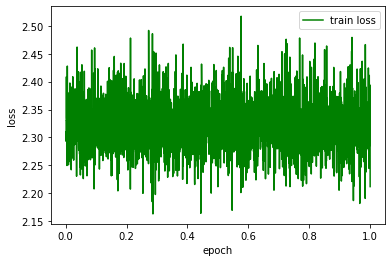

In [69]:
# 3層, 初期値ガウス分布、tanh使用の結果
network = ScratchDeepNeuralNetworkClassifier()
network.fit(X_train, y_train, X_val, y_val, epochs=1)

In [70]:
pred = network.predict(X_test, y_test)

from sklearn import metrics

print(f'予測結果の正解率: {metrics.accuracy_score(y_test, pred)}')

予測結果の正解率: 0.1028


学習はできてはいるが、今回の実装だとエポックを増やしてもlossの改善が見られなかった。<br>
また、１次元畳み込み層を1層目としたが、フィルタサイズの設定を力業で行っている。<br>
その為、入力データサイズの変化に対応できず、不便な実装になってしまっている。<br>